In [1]:
import matplotlib


In [8]:
import pandas as pd
import polars as pl
import networkx as nx

import numpy as np
from itertools import combinations

#методы эмбеддингов:
#import umap
from sklearn.manifold import SpectralEmbedding, Isomap
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import powerlaw


import scipy as sp
from matplotlib import pyplot as plt


In [38]:
G = nx.powerlaw_cluster_graph(10000, 2, 0.002)

In [7]:
#coalescent embedding - предварительное взвешнивание графа


def number_of_common_neighbors(g):
    """
    Optimized calculation of the number of common neighbors.
    """
    adj = nx.to_numpy_array(g)
    return adj @ adj

def external_degree(g):
    """
    Optimized calculation of external degrees.
    """
    adj = nx.to_numpy_array(g)
    degree = adj.sum(axis=1)  # Степень узлов
    cn = number_of_common_neighbors(g)  # Оптимизированные общие соседи
    ext_degree = (degree[:, None] - cn - 1) * adj
    return ext_degree.T

def RA1_weights(g):
    """
    Optimized RA1 weights calculation.
    """
    degree = np.array(g.degree())[:, 1].astype(float)
    di, dj = np.meshgrid(degree, degree)
    cn = number_of_common_neighbors(g)
    return (di + dj + di * dj) / (1 + cn)

def RA2_weights(g):
    """
    Optimized RA2 weights calculation.
    """
    ei = external_degree(g)
    cn = number_of_common_neighbors(g)
    return (ei + ei.T + ei * ei.T) / (1 + cn)

def EBC_weights(g):
    """
    Optimized edge betweenness centrality weights.
    """
    w = nx.edge_betweenness_centrality(g)
    edges = [(u, v, w_val) for (u, v), w_val in w.items()]
    _g = nx.Graph()
    _g.add_weighted_edges_from(edges)
    return nx.to_numpy_array(_g)

In [ ]:
#Генерация angular coordinates

# Функции для координат
def CA_coords(coords):
    return np.array(coords) / np.linalg.norm(coords, ord=2, axis=-1, keepdims=True)

def EA_coords(coords):
    zero_angle_vec = np.array([1, 0]).reshape((1, 2))
    coords = CA_coords(coords)
    angles = np.arctan2(coords[:, 1], coords[:, 0])
    inds = np.argsort(angles)
    rescaled = np.arange(len(coords))[inds]
    rescaled = rescaled * 2 * np.pi / len(coords)
    return np.stack((np.cos(rescaled), np.sin(rescaled)), axis=1)

# Функция для оценки параметра степенного распределения
def get_pl_exponent(G):
    degree = np.array([d for _, d in G.degree()])
    results = powerlaw.Fit(degree, verbose=False)
    return results.power_law.alpha

# Радиальная координата
def radial_coord_deg(G, beta, zeta=1):
    degrees = np.array([d for _, d in G.degree()]).astype(float)
    inds = np.argsort(-degrees)
    return 2 / zeta * (beta * np.log(inds + 1) + (1 - beta) * np.log(len(degrees)))



# Обновлённая функция hc_embedding с Isomap по умолчанию
def hc_embedding(
    G,
    pre_weighting='RA1',
    embedding=None,
    angular_func=EA_coords,
    n_neighbors=15,
    min_dist=0.1,   # теперь НЕ используется, оставлен только для совместимости сигнатуры
    n_jobs=12
):
    """
    Computes a hyperbolic coalescent embedding of a given graph using Isomap for dimensionality reduction
    (если embedding не передан).

    Args:
        G: networkx.Graph
            The input graph.
        pre_weighting: str or callable
            Determines the features that are passed to the dimensionality reduction method.
            If a string, it should be the name of the pre-weighting function (e.g., 'RA1' or 'RA2').
            If a callable, it should be a function that takes a graph and returns a weight matrix.
        embedding: Object
            An embedding model that implements the fit_transform method (like sklearn.manifold.Isomap
            or sklearn.manifold.SpectralEmbedding).
        angular_func: callable
            A function that computes angular coordinates from the embedding.
        n_neighbors: int
            The number of neighbors for Isomap (only used if embedding is None).
        min_dist: float
            Kept only for backward compatibility; not used with Isomap.
        n_jobs: int
            Number of parallel jobs for Isomap (only used if embedding is None).

    Returns:
        pd.DataFrame:
            A dataframe mapping nodes to their (x, y) spatial coordinates in the embedded space.
    """
    # Если передана строка, получить функцию по имени
    weight_func = {'RA1': RA1_weights}.get(pre_weighting)
    if weight_func is None:
        raise ValueError(f"Pre-weighting function '{pre_weighting}' not found.")
    
    # Вычисление весов (матрица признаков / похожести)
    weights = weight_func(G)
    
    # Если модель эмбеддинга не указана, используем Isomap
    if embedding is None:
        embedding_model = Isomap(
            n_components=2,
            n_neighbors=n_neighbors,
            n_jobs=n_jobs
        )
    else:
        embedding_model = embedding
    
    # Применяем модель эмбеддинга
    embedding = embedding_model.fit_transform(weights)
    
    # Угловые координаты
    angular_coords = angular_func(embedding)
    
    # Радиальные координаты
    gamma = get_pl_exponent(G)          # экспонента степенного распределения
    beta = 1.0 / (gamma - 1.0)

    radii = radial_coord_deg(G, beta)
    
    # Масштабируем угловые координаты радиусами
    coords = angular_coords * radii[..., None]
    
    # Сопоставляем узлы координатам
    node_ids = list(G.nodes)
    df = pd.DataFrame(coords, index=node_ids, columns=['x', 'y'])
    return df

In [22]:
#отрисовка графа (если он маленький)
def curved_edges(G, pos, dist_ratio=0.2, bezier_precision=20, polarity='random'):
    """
    Создаёт сглаженные кривые для рисунка.
    
    Args:
        G: networkx.Graph - граф.
        pos: dict - позиции узлов.
        dist_ratio: float - коэффициент, определяющий расстояние до контрольных точек.
        bezier_precision: int - число точек для построения кривой.
        polarity: str - направление изгиба ('random' или фиксированное).
        
    Returns:
        numpy.ndarray - массив точек для каждого ребра.
    """
    edges = np.array(G.edges())
    l = edges.shape[0]

    # Полярность изгиба
    rnd = np.where(np.random.randint(2, size=l) == 0, -1, 1) if polarity == 'random' else 1

    # Получение координат узлов для рёбер
    u, inv = np.unique(edges, return_inverse=True)
    coords = np.array([pos[x] for x in u])[inv].reshape([edges.shape[0], 2, edges.shape[1]])
    coords_node1, coords_node2 = coords[:, 0, :], coords[:, 1, :]

    # Вычисление контрольных точек
    midpoints = (coords_node1 + coords_node2) / 2  # Средняя точка ребра
    dist = dist_ratio * np.sqrt(np.sum((coords_node1 - coords_node2) ** 2, axis=1))  # Длина контрольной линии
    directions = np.column_stack((
        coords_node2[:, 1] - coords_node1[:, 1],  # Перпендикулярное направление
        -(coords_node2[:, 0] - coords_node1[:, 0])
    ))
    directions = directions / np.linalg.norm(directions, axis=1, keepdims=True)  # Нормализация
    control_points = midpoints + rnd[:, None] * directions * dist[:, None]  # Контрольные точки

    # Генерация кривых (линейный сплайн или квадратичная интерполяция)
    curves = []
    for i in range(l):
        # Стартовая, контрольная и конечная точки
        p0, p1, p2 = coords_node1[i], control_points[i], coords_node2[i]
        t = np.linspace(0, 1, bezier_precision)[:, None]
        curve = (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2  # Квадратичная интерполяция
        curves.append(curve)

    return np.array(curves)

In [39]:
emb = hc_embedding(G)

c:\Users\uvan6\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 12 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\uvan6\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\uvan6\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\uvan6\anaconda3\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\uvan6\anaconda3\L

In [40]:
emb

,x,y
0,1.006862,-9.736555
1,-6.906884,-7.504868
2,-1.449545,8.969596
3,6.043152,-8.575608
4,7.217376,-8.974039
...,...,...
9995,-16.510981,-6.887739
9996,0.236042,17.888138
9997,-17.867490,0.887621
9998,-15.009362,-9.738258


# Отрисовка вершин графа

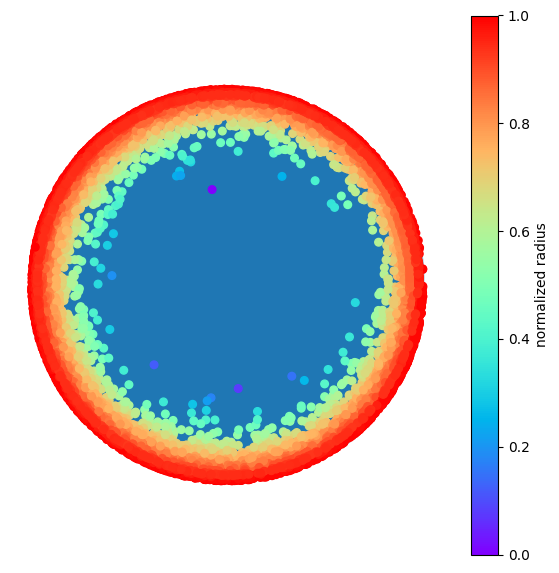

In [43]:
# 1. Преобразуем DataFrame с координатами в dict {node: (x, y)}
pos = {node: (row['x'], row['y']) for node, row in emb.iterrows()}

# 2. Получаем сглаженные ребра
edges_curves = curved_edges(G, pos)

# 3. Создаём LineCollection из кривых
lc = LineCollection(edges_curves, alpha=0.5)

# 3.5. Считаем радиус для каждого узла и нормируем его для цвета
x = emb['x'].values
y = emb['y'].values
r = np.sqrt(x**2 + y**2)                       # радиус от центра
r_norm = (r - r.min()) / (r.max() - r.min() + 1e-12)  # нормировка в [0, 1]

# 4. Рисуем
fig, ax = plt.subplots(figsize=(7, 7))

# сначала рёбра
ax.add_collection(lc)

color_type = 'rainbow' # можно 'coolwarm', 'rainbow', 'viridis', 'hsv' и т.п.


# узлы рисуем с теми же координатами pos и цветом по радиусу
nx.draw_networkx_nodes(
    G,
    pos=pos,
    ax=ax,
    node_size=30,
    node_color=r_norm,
    cmap=color_type
)

ax.autoscale()   # чтобы подогнать границы под коллекцию рёбер
ax.set_aspect('equal')
plt.axis('off')

# при желании показываем цветовую шкалу
sm = plt.cm.ScalarMappable(cmap=color_type)
sm.set_array(r_norm)
plt.colorbar(sm, ax=ax, label='normalized radius')

plt.show()
